# 3er entrega - Sistemas de recomendación

En esta entrega vamos a trabajar con un sistema de recomendación.

Vamos a aprovechar la competencia de Telecom que vimos ya que los datos son reales y están buenos para practicar.

En el siguiente repositorio pueden encontrar el significado de cada columna de los datasets:
https://github.com/Datathon2021/Recomendador

Consigna:

- Dividir set en train y test. Tomar como train los datos hasta el 1 de marzo de 2021. Desde el 1ro de marzo en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

Recomendaciones:
- En este caso no tenemos ratings explícitos como los casos que vimos, deben generar ustedes estos ratings mediante algún criterio. Lo más simple podría ser utilizar ratings binarios (lo vió / no lo vió).
- Hay una columna que nos indica hasta cuando va a estar disponible el contenido
- La columna **end_vod_date**: "fecha de finalización de la disponibilidad del activo en la plataforma" puede llegar a serles muy útil. ¿Tiene sentido recomendar algo que no va a estar disponible en el set de test? (a partir del 1 de marzo de 2021).
- Comiencen con algo SIMPLE. No se compliquen con todas las columnas que tiene el dataset. No van a necesitar usar todas, muchas columnas podrán descartarlas dependiendo del enfoque que tomen.

Datos:
- https://drive.google.com/file/d/1QjbqJvU0PTClEhReOyzr96BS-HpyyUKT/view?usp=sharing
- https://drive.google.com/file/d/1ih6SZc44w8FXdFKQJ2l-aqEWFpfceGuN/view?usp=sharing

Fecha de entrega: **30 de Enero de 2023**.

Subir a un repositorio de github (público) y enviar el link a alexispacek@gmail.com. De paso les sirve para ir armando su perfil de github con algunos proyectos 😉.



In [93]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [1]:
# Los de siempre
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# datetime
from datetime import datetime

# matrices
from scipy.sparse import csr_matrix

# models
from lightfm import LightFM
from tqdm import tqdm

C:\Users\Asus\anaconda3-2022\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Si hay problemas con la instalación de lightfm, abrir consola de conda y ejecutar lo siguiente:

In [ ]:
conda install -c conda-forge lightfm

Seteamos max_coldwidth

In [ ]:
pd.options.display.max_colwidth = 10000

Leemos train.csv y metadatos.csv

In [2]:
# df_train = pd.read_csv('/content/drive/MyDrive/Cursos/Especializacion en Data Science/Sprint 3/train.csv', delimiter=',')
df_train = pd.read_csv('c:/Users/Asus/Downloads/Curso Data Science - 2022/Cuarto Trabajo/data/train.csv', delimiter=',')
# df_train = pd.read_csv('./train.csv', delimiter=',')
df_train.head(1)

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0


In [3]:
# df_metadatos = pd.read_csv('/content/drive/MyDrive/Cursos/Especializacion en Data Science/Sprint 3/metadata.csv', delimiter=';')
df_metadatos = pd.read_csv('c:/Users/Asus/Downloads/Curso Data Science - 2022/Cuarto Trabajo/data/metadata.csv', delimiter=';')
# df_metadatos = pd.read_csv('./metadata.csv', delimiter=';')
df_metadatos.head(1)

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z


In [5]:
filas, columnas = df_train.shape
print("train.csv")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")
print(f"Cantidad de perfiles: {df_train.account_id.nunique()}")

train.csv
Cantidad de Filas: 3657801
Cantidad de Columnas: 7
Cantidad de perfiles: 113881


In [19]:
# Info de columnas
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   account_id   int64  
 2   device_type  object 
 3   asset_id     float64
 4   tunein       object 
 5   tuneout      object 
 6   resume       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 195.3+ MB
None


In [25]:
# Hay nulos?
print("nulos en train.csv")
df_train.isna().sum()

nulos en train.csv


customer_id     0
account_id      0
device_type    29
asset_id       22
tunein          0
tuneout         0
resume          0
dtype: int64

In [28]:
filas, columnas = df_metadatos.shape
print("metadatos.csv")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")
print(f"Cantidad de Videos: {df_metadatos.asset_id.nunique()}")

metadatos.csv
Cantidad de Filas: 33144
Cantidad de Columnas: 30
Cantidad de Videos: 33144


In [14]:
# Info de las columnas
df_metadatos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_id            33144 non-null  int64  
 1   content_id          33123 non-null  float64
 2   title               33144 non-null  object 
 3   reduced_title       33144 non-null  object 
 4   episode_title       28997 non-null  object 
 5   show_type           33140 non-null  object 
 6   released_year       33144 non-null  float64
 7   country_of_origin   33140 non-null  object 
 8   category            33144 non-null  object 
 9   keywords            33142 non-null  object 
 10  description         33142 non-null  object 
 11  reduced_desc        33144 non-null  object 
 12  cast_first_name     24412 non-null  object 
 13  credits_first_name  20590 non-null  object 
 14  run_time_min        33144 non-null  float64
 15  audience            33143 non-null  object 
 16  made

In [29]:
# Hay nulos?
print("nulos en metadatos.csv")
df_metadatos.isna().sum()

nulos en metadatos.csv


asset_id                  0
content_id               21
title                     0
reduced_title             0
episode_title          4147
show_type                 4
released_year             0
country_of_origin         4
category                  0
keywords                  2
description               2
reduced_desc              0
cast_first_name        8732
credits_first_name    12554
run_time_min              0
audience                  1
made_for_tv               0
close_caption             0
sex_rating                0
violence_rating           0
language_rating           0
dialog_rating             0
fv_rating                 0
pay_per_view              0
pack_premium_1            0
pack_premium_2            0
create_date               0
modify_date               0
start_vod_date            0
end_vod_date              0
dtype: int64

Mergeamos los dos dataset por asset_id

In [4]:
df = df_train.merge(df_metadatos, how="left", left_on="asset_id", right_on="asset_id")

In [31]:
filas, columnas = df.shape
print("- dataset mergeado -")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")

- dataset mergeado -
Cantidad de Filas: 3657801
Cantidad de Columnas: 36


Nos quedamos solo con los features que utilizaremos

In [5]:
df = df[[ 
        # df_train
        'customer_id', 'account_id', 'device_type', 'asset_id', 'tunein', 'tuneout', 'resume', 
        # df_metadatos
        'content_id', 'title', 'show_type', 'country_of_origin', 'category', 'run_time_min', 'end_vod_date'
        ]]

In [45]:
filas, columnas = df.shape
print("- dataset mergeado -")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")

- dataset mergeado -
Cantidad de Filas: 3657801
Cantidad de Columnas: 14


info y nulos del dataset

In [44]:
# Info de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657801 entries, 0 to 3657800
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   customer_id        int64  
 1   account_id         int64  
 2   device_type        object 
 3   asset_id           float64
 4   tunein             object 
 5   tuneout            object 
 6   resume             int64  
 7   content_id         float64
 8   title              object 
 9   show_type          object 
 10  country_of_origin  object 
 11  category           object 
 12  run_time_min       float64
 13  end_vod_date       object 
dtypes: float64(3), int64(3), object(8)
memory usage: 418.6+ MB


In [46]:
# Hay nulos?
df.isna().sum()

customer_id            0
account_id             0
device_type           29
asset_id              22
tunein                 0
tuneout                0
resume                 0
content_id           142
title                 22
show_type             35
country_of_origin     40
category              22
run_time_min          22
end_vod_date          22
dtype: int64

In [48]:
# Porcentaje de nulos
df.isna().mean()*100

customer_id          0.000000
account_id           0.000000
device_type          0.000793
asset_id             0.000601
tunein               0.000000
tuneout              0.000000
resume               0.000000
content_id           0.003882
title                0.000601
show_type            0.000957
country_of_origin    0.001094
category             0.000601
run_time_min         0.000601
end_vod_date         0.000601
dtype: float64

Decidimos eliminar los nulos porque son muy pocos registros

In [6]:
print(f"Antes: {df.shape[0]}")
df = df.dropna()
print(f"Ahora: {df.shape[0]}")

Antes: 3657801
Ahora: 3657599


Eliminamos duplicados si es que existen

In [7]:
print(f"Antes: {df.shape[0]}")
df = df.drop_duplicates(keep='first')
print(f"Ahora: {df.shape[0]}")

Antes: 3657599
Ahora: 3657561


Convertimos 'tunein' a YYYYmmDD, ya que lo utilizaremos para hacer el split para train y test

In [8]:
%%time
df['timestamp'] = pd.to_datetime(df['tunein'], format='%Y/%m/%d')
df['timestamp'] = df['timestamp'].dt.strftime('%Y/%m/%d')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d')
df[['tunein', 'timestamp']].head(1)

Wall time: 34.3 s


,tunein,timestamp
0,2021-02-18 22:52:00.0,2021-02-18


Calculamos los minutos de visualizacion del contenido por el usuario

In [9]:
%%time
df['from'] =  pd.to_datetime(df['tunein'], format='%Y-%m-%d %H:%M:%S.%f')
df['to'] =  pd.to_datetime(df['tuneout'], format='%Y-%m-%d %H:%M:%S.%f')
df['resultado'] = df['to'] - df['from']
df['minutos_vistos'] = df['resultado'].dt.seconds.div(60).astype(float) 
df[['from','to','resultado','minutos_vistos']].head(2)

Wall time: 6.27 s


,from,to,resultado,minutos_vistos
0,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,43.0
1,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,44.0


end_vod_date

In [10]:
df['end_vod_date'] = pd.to_datetime(df['end_vod_date'], format='%Y/%m/%d')
df["end_vod_date"] = pd.to_datetime(df["end_vod_date"]).dt.date

Fecha mínima y máxima del dataset

In [55]:
df.timestamp.min()

Timestamp('2021-01-01 00:00:00')

In [56]:
df.timestamp.max()

Timestamp('2021-03-31 00:00:00')

Clientes y Perfiles

In [91]:
print(f'Número de clientes: {df["customer_id"].nunique()}')
print(f'Número de perfiles: {df["account_id"].nunique()}')

Número de clientes: 112332
Número de perfiles: 113873


In [104]:
# Perfiles por cliente
df_copy = df[['customer_id','account_id']].copy()
print(df_copy.shape)
df_copy = df_copy.drop_duplicates(keep='first')
print(df_copy.shape)
print(df_copy.groupby('customer_id').size() \
    .sort_values(ascending=False))

print("Vemos que el nro max de perfiles por cliente es de 3 y el mínimo de 1.")

(3657561, 2)
(113873, 2)
customer_id
16323     3
37871     3
55768     3
32546     3
29641     3
         ..
37705     1
37704     1
37703     1
37702     1
112339    1
Length: 112332, dtype: int64
Vemos que el nro max de perfiles por cliente es de 3 y el mínimo de 1.


Assets y contenidos

In [105]:
print(f'Número de contents: {df["content_id"].nunique()}')
print(f'Númerico de assets: {df["asset_id"].nunique()}')

Number of unique assets: 23973
Number of unique contents: 4061


In [73]:
df_copy = df[['content_id','asset_id']].copy()
df_copy = df_copy.drop_duplicates(keep='first')
aux = df_copy.groupby('content_id').size() \
            .sort_values(ascending=False)
print(aux)
print("Vemos que el nro max de assets por contenido es de 205.")

content_id
1879.0    205
176.0     195
387.0     171
1769.0    170
1573.0    168
         ... 
2429.0      1
2430.0      1
2431.0      1
2432.0      1
4371.0      1
Length: 4061, dtype: int64
Vemos que el nro max de assets por contenido es de 205.


Cantidad de visualizaciones por año:

In [74]:
plot_df = df.copy()
plot_df["year"] = plot_df.timestamp.dt.year
plot_df = plot_df.groupby("year", as_index=False).count()[["year", "customer_id"]]
plot_df.columns = ["year", "visualizations_count"]
plot_df.head()

,year,visualizations_count
0,2021,3657561


Cantidad de reviews por mes:

In [60]:
plot_df = df.copy()
plot_df["month"] = plot_df.timestamp.dt.month
plot_df = plot_df.groupby("month", as_index=False).count()[["month", "customer_id"]]
plot_df.columns = ["month", "visualizations_count"]
plot_df.head()

,month,visualizations_count
0,1,1216404
1,2,1122548
2,3,1318609


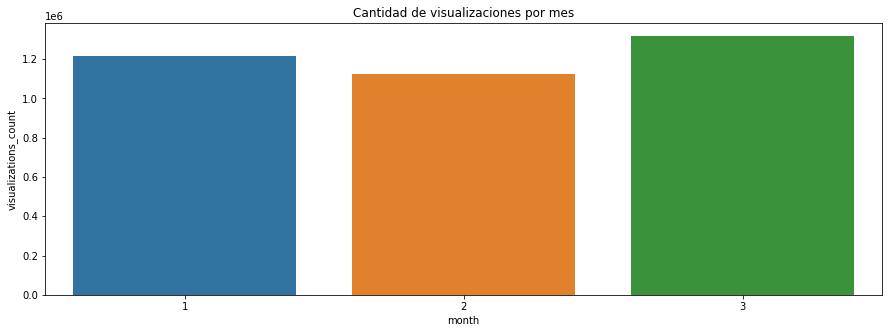

In [63]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=plot_df.month, y=plot_df.visualizations_count)
plt.title("Cantidad de visualizaciones por mes")
plt.show()

Cantidad de visualizaciones por tipo de dispositivo

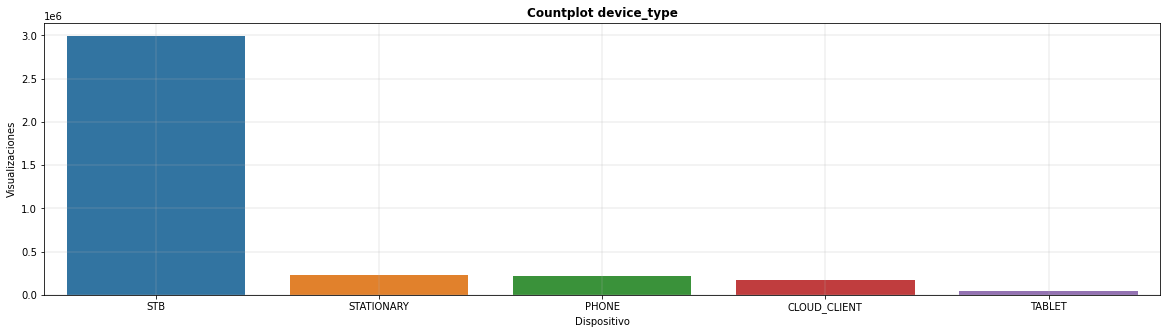

In [87]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(data=df, x='device_type', order=df['device_type'].value_counts().iloc[:10].index)
# for container in ax.containers:
  #  ax.bar_label(container)
plt.xlabel('Dispositivo')
plt.ylabel('Visualizaciones')
plt.grid(linewidth=0.3)
plt.title('Countplot device_type', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

Cantidad de visualizaciones por country_of_origin

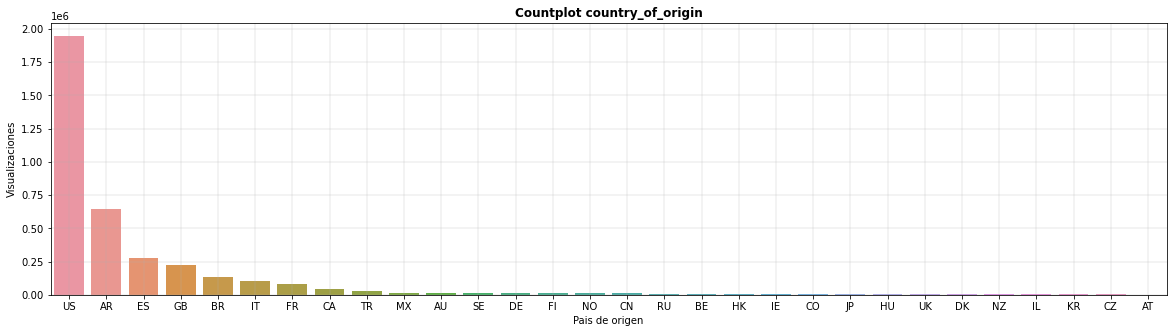

In [88]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(data=df, x='country_of_origin', order=df['country_of_origin'].value_counts().iloc[:30].index)
# for container in ax.containers:
  #  ax.bar_label(container)
plt.xlabel('Pais de origen')
plt.ylabel('Visualizaciones')
plt.grid(linewidth=0.3)
plt.title('Countplot country_of_origin', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

Cantidad de visualizaciones por tipo

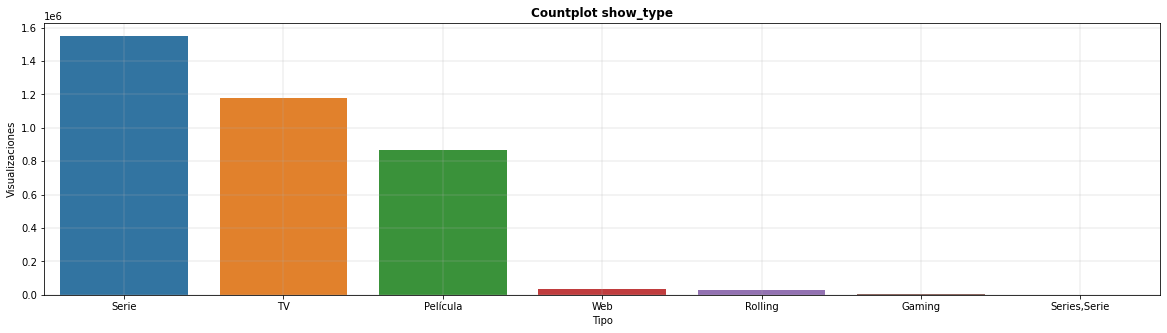

In [90]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(data=df, x='show_type', order=df['show_type'].value_counts().iloc[:30].index)
# for container in ax.containers:
  #  ax.bar_label(container)
plt.xlabel('Tipo')
plt.ylabel('Visualizaciones')
plt.grid(linewidth=0.3)
plt.title('Countplot show_type', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

Cantidad de visualizaciones por perfil:

In [69]:
df.groupby(['customer_id','account_id'])['minutos_vistos'].size() \
    .sort_values(ascending=False)

customer_id  account_id
36854        7107          3612
79889        99113         2256
110394       24556         1836
66280        84543         1692
82636        102343        1631
                           ... 
63723        81792            1
104846       20298            1
89143        112093           1
37062        56865            1
96239        13682            1
Name: minutos_vistos, Length: 113873, dtype: int64

Cantidad de visualizaciones por perfil y content_id:

In [75]:
df.groupby(['customer_id','account_id','content_id'])['minutos_vistos'].size() \
    .sort_values(ascending=False)

customer_id  account_id  content_id
36854        7107        491.0         1885
109693       3042        562.0         1246
46409        65203       712.0         1242
25204        46522       1139.0        1187
32154        52503       2160.0        1104
                                       ... 
66855        96285       2942.0           1
                         3483.0           1
                         3592.0           1
                         3749.0           1
58814        76671       1986.0           1
Name: minutos_vistos, Length: 971443, dtype: int64

In [76]:
df[(df['customer_id'] == 36854) & ( df['account_id']==7107) & (df['content_id']==491)].head(3)

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,show_type,...,run_time_min,end_vod_date,timestamp,from,to,resultado,minutos_vistos,rating_1,rating_2,rating_3
1087982,36854,7107,STB,15150.0,2021-01-01 08:46:00.0,2021-01-01 08:49:00.0,0,491.0,T:1 Ep:01 La Granja de Zenón: La Serie,TV,...,3.0,2021-09-17T23:59:00.0Z,2021-01-01,2021-01-01 08:46:00,2021-01-01 08:49:00,0 days 00:03:00,3.0,1,0,1
1087983,36854,7107,STB,31410.0,2021-01-01 08:50:00.0,2021-01-01 08:53:00.0,0,491.0,T:1 Ep:02 La Granja de Zenón: La Serie,TV,...,3.0,2021-09-17T23:59:00.0Z,2021-01-01,2021-01-01 08:50:00,2021-01-01 08:53:00,0 days 00:03:00,3.0,1,0,1
1088006,36854,7107,STB,15150.0,2021-01-02 12:42:00.0,2021-01-02 12:45:00.0,1,491.0,T:1 Ep:01 La Granja de Zenón: La Serie,TV,...,3.0,2021-09-17T23:59:00.0Z,2021-01-02,2021-01-02 12:42:00,2021-01-02 12:45:00,0 days 00:03:00,3.0,1,1,1


In [79]:
# Sumamos los minutos que vio el perfil 7107 sobre el video 491
print('Sumamos los minutos que vio el perfil 7107 sobre el video 491')
df[( df['account_id']==7107) & (df['content_id']==491)].groupby(['customer_id','account_id','content_id','asset_id'])['minutos_vistos'].sum() \
    .sort_values(ascending=False)

Sumamos los minutos que vio el perfil 7107 sobre el video 491


customer_id  account_id  content_id  asset_id
36854        7107        491.0       24096.0     774.0
                                     11479.0     715.0
                                     6805.0      708.0
                                     31410.0     630.0
                                     31895.0     577.0
                                     29759.0     567.0
                                     15143.0     427.0
                                     5757.0      402.0
                                     16228.0     387.0
                                     30710.0     386.0
                                     3205.0      302.0
                                     15150.0     273.0
Name: minutos_vistos, dtype: float64

In [80]:
# vemos cuanto dura el video anterior.
df_metadatos[(df_metadatos['content_id']==491)].groupby(['content_id'])['run_time_min'].sum() \
    .sort_values(ascending=False)

content_id
491.0    72.0
Name: run_time_min, dtype: float64

Duracion de los contenidos

In [83]:
print(f"Duracion mínima de un video: {df['run_time_min'].min()}")
print(f"Duracion máxima de un video: {df['run_time_min'].max()}")


print(f"Cantidad de videos con duracion mínima: {df[df['run_time_min'] == df['run_time_min'].min()].count().iloc[1]}")
print(f"Cantidad de videos con duracion máxima: {df[df['run_time_min'] == df['run_time_min'].max()].count().iloc[1]}")


Duracion mínima de un video: 0.0
Duracion máxima de un video: 305.0
Cantidad de videos con duracion mínima: 310
Cantidad de videos con duracion máxima: 11


In [ ]:
# columns = ['account_id', 'asset_id', 'tunein', 'tuneout', 'timestamp', 'minutos']
# df_filtered = df.drop_duplicates(subset = ['account_id', 'asset_id'])[columns]
# df_filtered.head(1)

In [204]:
# df_duracion = df_metadatos.groupby('content_id').agg({'run_time_min': 'sum'}).reset_index()
# df_duracion
#df_duracion.set_index(keys='content_id',inplace=True)

#df_visualizacion = df_train.groupby(['account_id','asset_id']).agg({'minutos':'sum'}).reset_index()
#df_visualizacion.set_index(keys=['account_id','asset_id'],inplace=True)

In [205]:
# df_duracion[df_duracion.content_id == 4][['run_time_min']]

In [130]:
# df_visualizacion.loc[(0,6397)]['minutos']
# #df.loc[('M-1','Test1')]

In [206]:
#df_metadatos[df_metadatos.content_id == 1].groupby(['content_id']).agg({'run_time_min':'sum'})['run_time_min']
#df[(df.account_id == 1) & (df.content_id == 1020)].groupby(['account_id','content_id']).agg({'minutos_vistos':'sum'})['minutos_vistos'] 
#df_duracion[df_duracion.content_id == 1503].iloc[0]['run_time_min']


In [191]:
# def calcular(content_id):
#     return df_duracion[df_duracion.content_id == content_id].iloc[0]['run_time_min']

In [207]:
# %%time
# df_aux = df.groupby(['account_id','content_id']).agg({'minutos_vistos':'sum'}).reset_index()
# df_aux['duracion'] = df_aux.content_id.apply(calcular)

In [165]:
# df_aux = df[['account_id','content_id']].copy()
# df_aux.drop_duplicates(subset = ['account_id', 'content_id'], inplace=True)

In [208]:
# user_ids = df.account_id.value_counts().index

# for user_id in tqdm(user_ids):
#     content_ids = df[df.account_id == user_id].content_id.value_counts().index
#     for content_id in content_ids:
#         duracion_pelicula = df_duracion[df_duracion.content_id == content_id]['run_time_min'].index
        
        

        #lo_que_yo_vi = df[(df.account_id == user_id) & (df.content_id == content_id)].groupby(['account_id','content_id']).agg({'minutos_vistos':'sum'})['minutos_vistos'] 

        #rating = lo_que_yo_vi * 100 / duracion_pelicula
        
        
#         mask = df_aux[(df_aux.content_id == content_id) & (df_aux.account_id == user_id)].index
#         df_aux.loc[mask, 'rating_4'] = rating        

In [ ]:
# for tupla in tqdm(list):
#     mask = df_filtered[(df_filtered.asset_id == tupla[1]) & (df_filtered.account_id == tupla[0])].index
#     df_filtered.loc[mask, 'rating'] = tupla[2]   

In [ ]:
# df_filtered.to_csv('df_filtered', sep='\t')
# # df.to_csv(file_name, sep='\t', encoding='utf-8')

<b> Calculamos el rating </b>

Opcion 1: Baseline 

Si vió el contenido entonces le gusto.

In [11]:
df['rating_1'] = 1

Opcion 2: Campo RESUME

Si el campo 'resume' es 1, es decir, volvió a ver el contenido, entonces le gusto.

In [12]:
df['rating_2'] = df.resume.apply(lambda x : 1 if x == 1 else 0)

Opción 3: Porcentajes de visualización

Si vio más del 50% de la duración del asset, entonces significa que le gusto.

In [13]:
df['rating_3'] = df['run_time_min'] * 0.3 - df['minutos_vistos'] 
df['rating_3'] = df['rating_3'].apply(lambda x: 1 if x <= 0 else 0)

Opción 4: Porcentaje de visualización total

La idea es calcular el porcentaje de visualización de cada asset vistos por cada perfil, respecto a la duración total del asset. De esta forma sabemos qué tanto vio el usuario de cada asset, y así determinar el rating.

In [195]:
def calcular(content_id):
    return df_duracion[df_duracion.content_id == content_id].iloc[0]['run_time_min']

In [196]:
df_duracion = df_metadatos.groupby('content_id').agg({'run_time_min': 'sum'}).reset_index()

In [197]:
df_aux = df.groupby(['account_id','content_id']).agg({'minutos_vistos':'sum'}).reset_index()

In [198]:
%%time
df_aux['duracion'] = df_aux.content_id.apply(calcular)

Wall time: 5min 20s


In [199]:
%%time
df_aux['porcentaje'] = df_aux.minutos_vistos * 100 / df_aux.duracion

Wall time: 934 ms


In [200]:
%%time
df_aux['rating'] = df_aux.porcentaje.apply(lambda x : 1 if x > 40 else 0)

Wall time: 279 ms


In [202]:
def buscar_rating(account_id, content_id):
    return df_aux[(df_aux.account_id == account_id) &(df_aux.content_id == content_id)].iloc[0]['rating']

Train y Test

In [14]:
%%time
print(f'Número de filas antes de eliminar duplicados: {len(df)}')
df_main = df.drop_duplicates(subset=['account_id', 'content_id'], keep='last') 
print(f'Número de filas después de eliminar duplicados: {len(df_main)}') #2589602

Número de filas antes de eliminar duplicados: 3657561
Número de filas después de eliminar duplicados: 971443
Wall time: 1.75 s


In [219]:
df_main.head(1)

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,show_type,...,run_time_min,end_vod_date,from,to,resultado,minutos_vistos,rating_1,rating_2,rating_3,timestamp
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2040.0,T:5 Ep:10 This is Us,Serie,...,42.0,2021-06-30T23:59:59.0Z,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,44.0,1,0,1,2021-03-24


In [208]:
%%time
df_main['rating_4'] = df_main.apply(lambda x : buscar_rating(x.account_id, x.content_id), axis=1)

Wall time: 46min 51s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [213]:
df_main[(df_main.content_id == 491) & (df_main.account_id == 7107)]


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,show_type,...,category,run_time_min,end_vod_date,from,to,resultado,minutos_vistos,rating_1,rating_2,rating_3
1091592,36854,7107,STB,29759.0,2021-03-31 18:38:00.0,2021-03-31 19:19:00.0,0,491.0,T:1 Ep:07 La Granja de Zenón: La Serie,TV,...,Infantil/Dibujos Animados,3.0,2021-09-17T23:59:00.0Z,2021-03-31 18:38:00,2021-03-31 19:19:00,0 days 00:41:00,41.0,1,0,1


In [15]:
# ratings.drop(['customer_id','asset_id','tunein','tuneout','minutos','from','to','resultado','title', 'run_time_min', 'start_vod_date', 'end_vod_date', 'minutos_vistos', 'porcentaje_visto'],axis=1, inplace=True)
# ratings.drop(['customer_id','asset_id','tunein','tuneout','minutos','title', 'run_time_min', 'start_vod_date', 'end_vod_date', 'minutos_vistos', 'porcentaje_visto'],axis=1, inplace=True)
ratings = df_main[['account_id', 'content_id', 'rating_1', 'rating_2', 'rating_3', 'timestamp']].copy()
ratings.head()

,account_id,content_id,rating_1,rating_2,rating_3,timestamp
1,90627,2040.0,1,0,1,2021-03-24
3,3387,1983.0,1,1,1,2021-03-15
5,3387,729.0,1,0,0,2021-03-16
12,3388,691.0,1,0,1,2021-01-05
30,3388,3487.0,1,1,0,2021-01-24


In [16]:
# set de train
train = ratings[(ratings.timestamp < datetime(year=2021, month=3, day=1))]
train.head()

,account_id,content_id,rating_1,rating_2,rating_3,timestamp
12,3388,691.0,1,0,1,2021-01-05
30,3388,3487.0,1,1,0,2021-01-24
38,3388,3038.0,1,0,1,2021-02-08
48,3388,2100.0,1,0,0,2021-02-21
62,3389,604.0,1,0,1,2021-01-26


In [222]:
train.groupby(['account_id','content_id'])['content_id'].size() \
    .sort_values(ascending=False)

account_id  content_id
0           1503.0        1
79865       2434.0        1
            3550.0        1
            3748.0        1
79866       171.0         1
                         ..
43541       3532.0        1
43542       302.0         1
            2019.0        1
            3026.0        1
111465      3936.0        1
Name: content_id, Length: 612071, dtype: int64

In [223]:
train.shape

(612071, 6)

In [217]:
train.account_id.nunique()

95758

In [35]:
# set de test
test = ratings[ratings.timestamp >= datetime(year=2021, month=3, day=1)]
test.head()

,account_id,content_id,rating_1,rating_2,rating_3,timestamp
1,90627,2040.0,1,0,1,2021-03-24
3,3387,1983.0,1,1,1,2021-03-15
5,3387,729.0,1,0,0,2021-03-16
60,3388,3386.0,1,1,1,2021-03-29
61,3388,2040.0,1,1,1,2021-03-30


In [219]:
test.shape

(359372, 7)

In [220]:
test.account_id.nunique()

87623

¿Tenemos usuarios que aparecen en test pero no en train? 

In [329]:
test[~test.account_id.isin(train.account_id.unique())].account_id.nunique()

18115

Como vemos, tenemos este problema. Utilizaremos "cold start" al momento de recomendar a estos usuarios.

Armamos la matriz de interacción.

In [17]:
matrix_columns_1 = ["account_id","content_id", "rating_1"]
matrix_columns_2 = ["account_id","content_id", "rating_2"]
matrix_columns_3 = ["account_id","content_id", "rating_3"]
matrix_columns_4 = ["account_id","content_id", "rating_4"]

In [67]:
%%time
interactions_1 = train[matrix_columns_1]
interactions_2 = train[matrix_columns_2]
# interactions_3 = train[matrix_columns_3]
# interactions_4 = train[matrix_columns_4]

interactions_1.head(1)

Wall time: 15 ms


,account_id,content_id,rating_1
12,3388,691.0,1


In [68]:
def pivotear_df(interactions, matrix_columns):
    return pd.pivot_table(interactions[matrix_columns], index=matrix_columns[0], columns=matrix_columns[1], values=matrix_columns[2])

In [20]:
%%time
interactions_matrix_1 = pivotear_df(interactions_1, matrix_columns_1)
interactions_matrix_1.head() 

Wall time: 7min 52s


content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
%%time
interactions_matrix_2 = pivotear_df(interactions_2, matrix_columns_2)

Wall time: 16min


In [ ]:
%%time
interactions_matrix_3 = pivotear_df(interactions_3, matrix_columns_3)

In [ ]:
%%time
interactions_matrix_4 = pivotear_df(interactions_4, matrix_columns_4)

In [21]:
# %%time
# tarda 15 minutos
# interactions_matrix = pd.pivot(index="account_id", columns="content_id", values="rating")
# interactions_matrix_1 = pd.pivot_table(interactions_1[["account_id","content_id", "rating_1"]], index='account_id', columns='content_id', values='rating_1')
# interactions_matrix_1.head() 

Completo los NaN con ceros

In [22]:
%%time
interactions_matrix_1 = interactions_matrix_1.fillna(0)
interactions_matrix_1.head()

Wall time: 49.6 s


content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
%%time
interactions_matrix_2 = interactions_matrix_2.fillna(0)

Wall time: 5.68 s


In [ ]:
%%time
interactions_matrix_3 = interactions_matrix_3.fillna(0)

In [ ]:
%%time
interactions_matrix_4 = interactions_matrix_4.fillna(0)

¿Cuántas filas y columnas tiene la matriz de interacción?

In [303]:
print(f"Matriz 1 tiene : {interactions_matrix_1.shape[0]} filas y {interactions_matrix_1.shape[1]} columnas")
print(f"Matriz 2 tiene : {interactions_matrix_2.shape[0]} filas y {interactions_matrix_2.shape[1]} columnas")
print(f"Matriz 3 tiene : {interactions_matrix_3.shape[0]} filas y {interactions_matrix_3.shape[1]} columnas")
print(f"Matriz 4 tiene : {interactions_matrix_4.shape[0]} filas y {interactions_matrix_4.shape[1]} columnas")

Matriz 1 tiene : 95758 filas y 3688 columnas
Matriz 1 tiene : 95758 filas y 3688 columnas


Generemos diccionarios de usuarios y items

In [23]:
%%time
# user_id = list(interactions_matrix_1.index)
user_id = interactions_matrix_1.index
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

Wall time: 412 ms
Parser   : 365 ms


In [24]:
%%time
# item_id = list(interactions_matrix_1.columns)
item_id = interactions_matrix_1.columns
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

Wall time: 24 ms


Transformamos la matriz a csr matrix (compressed sparse row)

In [25]:
%%time
interactions_matrix_csr_1 = csr_matrix(interactions_matrix_1.values)

Wall time: 8.72 s
Parser   : 140 ms


In [71]:
%%time
interactions_matrix_csr_2 = csr_matrix(interactions_matrix_2.values)

Wall time: 8.12 s


In [ ]:
%%time
interactions_matrix_csr_3 = csr_matrix(interactions_matrix_3.values)

In [ ]:
%%time
interactions_matrix_csr_4 = csr_matrix(interactions_matrix_4.values)

In [248]:
print(f"Matriz 1 : {interactions_matrix_csr_1.shape}")
print(f"Matriz 2 : {interactions_matrix_csr_2.shape}")
print(f"Matriz 3 : {interactions_matrix_csr_3.shape}")
print(f"Matriz 4 : {interactions_matrix_csr_4.shape}")

(95758, 3688)

# Modelo

Utilizaremos la librería LFM (light fm) para realizar un modelo de recomendación.

In [249]:
# model = LightFM(random_state=0,
#                 loss='warp',
#                 learning_rate=0.03,
#                 no_components=100)

Entrenar el modelo con la matriz csr por 10 epochs:

In [250]:
# %%time
# model = model.fit(interactions_matrix_csr_1, epochs=10)

Wall time: 2min 12s
Parser   : 289 ms


Probando el modelo para un usuario cualquiera

In [251]:
# %%time
# user_x = user_dict[18]
# n_users, n_items = interactions_matrix_1.shape
# item_ids = np.arange(n_items)
# #ACA GENERAMOS PREDICCIONES
# preds = model.predict(user_ids=user_x, item_ids = item_ids)

Wall time: 418 ms
Parser   : 350 ms


Este array que obtenemos son los scores que le da el modelo a cada item para el usuario 18. Podemos ordenarlo y obtener las mejores recomendaciones

In [254]:
# scores = pd.Series(preds)
# scores.index = interactions_matrix_1.columns
# # recomms_18 = list(pd.Series(scores.sort_values(ascending=False).index))[:10] #obtenemos las primeras 10
# recomms_18 = pd.Series(scores.sort_values(ascending=False).index)[:10] #obtenemos las primeras 10

In [304]:
# recomms_18

Contenido no diponible a partir del 31-03-2021

In [ ]:
# not_available_content_until15march = df_drop[df_drop['end_vod_date'] < datetime(year=2021, month=3, day=15)]\
#    ['content_id'].values

# cold start
# most_popular_content = train.groupby('content_id', as_index=False).agg({'account_id':'nunique'})\
  #  .sort_values(by='account_id', ascending=False)
# most_popular = most_popular_content['content_id'][0:40].values
# most_popular = [x for x in most_popular if x not in not_available_content_until15march]




In [60]:
# Me quedo con content_id y su maxima end_vod_date
not_available_content_df = df[['content_id', 'end_vod_date']].groupby('content_id', as_index=False).agg({'end_vod_date': 'max'})
not_available_content = not_available_content_df[not_available_content_df['end_vod_date'] < datetime(year=2021, month=3, day=31).date()]['content_id'].values

print(f"Cantidad de contenido no disponible a partir de 31-03-2021: {len(not_available_content)}")

Cantidad de contenido no disponible a partir de 31-03-2021: 822


Popularidad de contenido para cold start

In [58]:
popularity_df = train.groupby("content_id", as_index=False).agg({"account_id":"nunique"})\
    .sort_values(by="account_id", ascending=False) 

most_popular = popularity_df['content_id'][0:50].values
most_popular = [x for x in most_popular if x not in not_available_content]

popularity_df.head(10).content_id.values

In [28]:
# not_available_content_until15march = df[df['end_vod_date'] < datetime(year=2021, month=3, day=15)] \
#     ['content_id'].values

# popularity_df = train.groupby("content_id", as_index=False).agg({"account_id":"nunique"}) \ 
#     .sort_values(by="account_id", ascending=False)

# popularity_df.columns=["content_id", "popularity"]
# popularity_df.head()

# most_popular = popularity_df['content_id'][0:50].values
# most_popular = [x for x in most_popular if x not in not_available_content_until15march]

In [29]:
# popularity_df.head(10).content_id.values

array([3806., 3900., 2040., 3598., 3381., 3690., 3210., 3550., 3384.,
       3711.])

Creando nuestra función de recomendación

In [61]:
def recomm(interactions_matrix, interactions_matrix_csr, not_available_content, most_popular):
    
    # Creo el modelo
    model = LightFM(random_state=0,
                loss='warp',
                learning_rate=0.03,
                no_components=100)
    
    # Entreno el modelo
    model = model.fit(interactions_matrix_csr, epochs=10)
    
    
    #definimos dict donde vamos a ir almacenando las recomendaciones
    recomms_dict = {
        'user_id': [],
        'recomms': [],
        'cold': []
    }

    #obtenemos cantidad de usuarios y cantidad de items
    n_users, n_items = interactions_matrix.shape
    item_ids = np.arange(n_items)

    #por cada usuario del dataset completo, generamos recomendaciones
    for user in tqdm(test.account_id.unique()): 

        # if user in list(interactions_matrix_1.index):
        if user in interactions_matrix.index:

            # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
            user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

           
            preds = model.predict(user_ids=user_x, item_ids = item_ids)

            
            scores = pd.Series(preds)
            scores.index = interactions_matrix.columns
            # scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]
            scores = pd.Series(scores.sort_values(ascending=False).index)[:50]

            # Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
            watched_contents = train[train.account_id == user].content_id.unique()

            #COMPLETAR: Filtrar contenidos ya vistos y quedarse con los primeros 10
            recomms = [x for x in scores if x not in watched_contents]
            recomms = [x for x in recomms if x not in not_available_content]

            # Guardamos las recomendaciones en el diccionario
            recomms_dict['user_id'].append(user)
            recomms_dict['recomms'].append(recomms[0:20])
            recomms_dict['cold'].append(False)

        # En este else trataremos a los usuarios que no están en la matriz (cold start)
        else:
            recomms_dict['user_id'].append(user)
            # Les recomendamos contenido popular
            # recomms_dict['recomms'].append(popularity_df.content_id.to_list())
            recomms_dict['recomms'].append(most_popular)
            recomms_dict['cold'].append(True)
    return recomms_dict

Ya tenemos la función de recomendaciones. La probamos

# Ahora obtenemos las recomendaciones para todos los usuarios

Primero comenzamos armando un listado de usuarios "non cold" a los cuales les daremos recomms personalizadas.

In [31]:
# Todos lo usuarios
users = df.account_id.unique() 
# Usuarios no cold
non_cold_users = train.account_id.unique()

print(len(users), len(non_cold_users)) # 113881 99649

113873 95758


In [62]:
%%time
recomms_dict_1 = recomm(interactions_matrix_1, interactions_matrix_csr_1, not_available_content, most_popular)

100%|███████████████████████████████████████████████████████████████████████████| 87623/87623 [04:02<00:00, 360.72it/s]


Wall time: 6min 2s


In [72]:
%%time
recomms_dict_2 = recomm(interactions_matrix_2, interactions_matrix_csr_2, not_available_content, most_popular)

100%|███████████████████████████████████████████████████████████████████████████| 87623/87623 [04:28<00:00, 326.23it/s]

Wall time: 5min 16s


In [ ]:
%%time
recomms_dict_3 = recomm(interactions_matrix_3, interactions_matrix_csr_3, not_available_content, most_popular)

In [ ]:
%%time
recomms_dict_4 = recomm(interactions_matrix_4, interactions_matrix_csr_4, not_available_content, most_popular)

In [286]:
# %%time

# #definimos dict donde vamos a ir almacenando las recomendaciones
# recomms_dict = {
#     'user_id': [],
#     'recomms': [],
#     'cold': []
# }

# #obtenemos cantidad de usuarios y cantidad de items
# n_users, n_items = interactions_matrix_1.shape
# item_ids = np.arange(n_items)

# #por cada usuario del dataset completo, generamos recomendaciones
# for user in tqdm(test.account_id.unique()): ### CUIDADO: USAR TEST - test.account_id.unique()
    
#     # if user in list(interactions_matrix_1.index):
#     if user in interactions_matrix_1.index:
      
#         # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
#         user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

#         #COMPLETAR: Generar las predicciones para el usuario x
#         preds = model.predict(user_ids=user_x, item_ids = item_ids)

#         #COMPLETAR: Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
#         scores = pd.Series(preds)
#         scores.index = interactions_matrix_1.columns
#         # scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]
#         scores = pd.Series(scores.sort_values(ascending=False).index)[:50]

#         #COMPLETAR: Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
#         watched_contents = train[train.account_id == user].content_id.unique()

#         #COMPLETAR: Filtrar contenidos ya vistos y quedarse con los primeros 10
#         recomms = [x for x in scores if x not in watched_contents]
#         recomms = [x for x in recomms if x not in not_available_content_until15march]

#         # Guardamos las recomendaciones en el diccionario
#         recomms_dict['user_id'].append(user)
#         recomms_dict['recomms'].append(recomms[0:20])
#         recomms_dict['cold'].append(False)
    
#     # En este else trataremos a los usuarios que no están en la matriz (cold start)
#     else:
#         recomms_dict['user_id'].append(user)
#         # Les recomendamos contenido popular
#         # recomms_dict['recomms'].append(popularity_df.content_id.to_list())
#         recomms_dict['recomms'].append(most_popular)
#         recomms_dict['cold'].append(True)

100%|████████████████████████████████████████████████████████████████████████████| 87623/87623 [19:40<00:00, 74.23it/s]


Ahora tenemos un diccionario de recomedaciones. Lo vamos a convertir en dataframe para poder manipularlo más fácil (como estamos acostumbrados)

In [63]:
%%time
recomms_df_1 = pd.DataFrame(recomms_dict_1)
recomms_df_1.head()

Wall time: 659 ms


,user_id,recomms,cold
0,90627,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True
1,3387,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True
2,3388,"[2040.0, 116.0, 97.0, 3752.0, 3716.0, 1399.0, ...",False
3,3389,"[1020.0, 3806.0, 2815.0, 1582.0, 2091.0, 2178....",False
4,3393,"[3572.0, 37.0, 1178.0, 36.0, 3292.0, 38.0, 338...",False


In [73]:
%%time
recomms_df_2 = pd.DataFrame(recomms_dict_2)
recomms_df_2.head()

Wall time: 1.46 s


,user_id,recomms,cold
0,90627,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True
1,3387,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True
2,3388,"[3806.0, 2040.0, 116.0, 2815.0, 724.0, 3690.0,...",False
3,3389,"[3806.0, 3900.0, 3210.0, 3550.0, 2040.0, 2827....",False
4,3393,"[1178.0, 2815.0, 3806.0, 1500.0, 2972.0, 1449....",False


In [ ]:
%%time
recomms_df_3 = pd.DataFrame(recomms_dict_3)
recomms_df_3.head()

In [ ]:
%%time
recomms_df_4 = pd.DataFrame(recomms_dict_4)
recomms_df_4.head()

Ahora tenemos que comparar nuestras recomms contra lo que los usuarios realmente vieron (test).

Primero ordenamos libros según los ratings (mayor a menor) que dieron los usuarios en el set de test.

Luego, agrupamos y armamos un listado de libros para cada usuario.

Este es el listado "ideal" contra el que vamos a comparar nuestras recomendaciones.

In [44]:
# %%time
# ideal_recomms = test\
#                   .sort_values(by=["account_id", "rating_1"], ascending=False)\
#                   .groupby(["account_id"], as_index=False)\
#                   .agg({"content_id": "unique"})\
#                   .head()
# ideal_recomms.head()

Wall time: 4.54 s


,account_id,content_id
0,2,[433.0]
1,3,"[1949.0, 2409.0, 4010.0, 3169.0, 3487.0, 3980...."
2,4,"[2314.0, 728.0, 4129.0, 2344.0, 2341.0, 513.0,..."
3,5,[2259.0]
4,6,"[3902.0, 3211.0, 3386.0, 4065.0, 2900.0, 3388.0]"


In [64]:
%%time
ideal_recomms =\
    test\
    .sort_values(by=["account_id"], ascending=False)\
    .groupby(["account_id"], as_index=False)\
    .agg({"content_id": "unique"})
ideal_recomendations_df.head()

Wall time: 4.44 s


,account_id,content_id
0,2,[433.0]
1,3,"[3980.0, 3169.0, 4010.0, 2409.0, 1949.0, 3487...."
2,4,"[565.0, 4340.0, 2212.0, 513.0, 2341.0, 2344.0,..."
3,5,[2259.0]
4,6,"[3388.0, 4065.0, 3386.0, 3211.0, 3902.0, 2900.0]"


# Métricas

In [65]:
def calcular_MAP(ideal_recomms, recomms_df):
    df_map = ideal_recomms.merge(recomms_df, how="left", left_on="account_id", right_on="user_id")[["account_id", "content_id", "recomms"]]
    df_map.columns = ["user_id", "ideal", "recomms"]
    
    aps = [] # lista vacía para ir almacenando la AP de cada recomendación

    for pred, label in df_map[["ideal", "recomms"]].values:
        n = len(pred) # cantidad de elementos recomendados
        arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
        rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
        tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
        denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
        ap = (tp / denom).sum() / len(label) # average precision
        aps.append(ap)
    
    MAP = np.mean(aps)
    return MAP
#     print(f'mean average precision = {round(MAP, 5)}')

In [66]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_1)
print(f'mean average precision for option 1 = {round(MAP, 5)}')

mean average precision for option 1 = 0.01381
Wall time: 5.95 s


In [74]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_2)
print(f'mean average precision for option 2 = {round(MAP, 5)}')

mean average precision for option 2 = 0.00974
Wall time: 7.47 s
Parser   : 502 ms


In [ ]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_3)
print(f'mean average precision for option 3 = {round(MAP, 5)}')

In [ ]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_4)
print(f'mean average precision for option 4 = {round(MAP, 5)}')

In [295]:
# df_map = ideal_recomms.merge(recomms_df, how="left", left_on="account_id", right_on="user_id")[["account_id", "content_id", "recomms"]]
# df_map.columns = ["user_id", "ideal", "recomms"]
# df_map.head()

,user_id,ideal,recomms
0,2,[433.0],"[2178.0, 3900.0, 3806.0, 3382.0, 393.0, 2160.0..."
1,3,"[1949.0, 2409.0, 4010.0, 3169.0, 3487.0, 3980....","[3210.0, 3711.0, 2972.0, 3519.0, 518.0, 2012.0..."
2,4,"[2314.0, 728.0, 4129.0, 2344.0, 2341.0, 513.0,...","[3900.0, 2827.0, 3806.0, 3210.0, 3716.0, 3598...."
3,5,[2259.0],"[3806.0, 3900.0, 2160.0, 2040.0, 604.0, 3690.0..."
4,6,"[3902.0, 3211.0, 3386.0, 4065.0, 2900.0, 3388.0]","[3716.0, 116.0, 1140.0, 2040.0, 2868.0, 3900.0..."


In [296]:
# aps = [] # lista vacía para ir almacenando la AP de cada recomendación

# for pred, label in df_map[["ideal", "recomms"]].values:
#   n = len(pred) # cantidad de elementos recomendados
#   arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
#   rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
#   tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
#   denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
#   ap = (tp / denom).sum() / len(label) # average precision
#   aps.append(ap)

In [298]:
# MAP = np.mean(aps)
# print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.0
